In [3]:
#imports
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/elenaruiz/Documents/FNC')
import pandas as pd
import numpy as np
from src.utils import io
from src.fake_news_detector.core.classificators import LDA, QDA, helpers
import matplotlib.pyplot as plt

## Import dataset

In [67]:
articles = io.read_json_file('/home/elenaruiz/Documents/FNC/src/data/dataset_style.json')
df = pd.DataFrame(data=articles['articles'])


## Variables to classify

In [50]:
column_names = ['pert_different_words', 'title_sentiment', 'pert_total_nouns', 'n_words', 'mean_character_per_word' ]

df[column_names].head()

,pert_different_words,title_sentiment,pert_total_nouns,n_words,mean_character_per_word
0,0.696296,-0.5719,0.607407,135,6.096296
1,0.622951,-0.1027,0.612022,183,6.688525
2,0.818966,-0.4588,0.594828,116,5.896552
3,0.772727,-0.2023,0.439394,66,5.363636
4,0.818182,-0.4767,0.636364,66,6.454545


## Standarize

In [51]:
from sklearn.preprocessing import StandardScaler
x = df[column_names]

scaler = StandardScaler()
scaled_df = scaler.fit_transform(x)

dataset_std = pd.DataFrame(scaled_df, columns=column_names)

# Add factor label
dataset_std['fake'] = df['fake']
dataset_std.head()

,pert_different_words,title_sentiment,pert_total_nouns,n_words,mean_character_per_word,fake
0,-0.649147,-1.167710,-0.096697,-0.581606,-0.409509,True
1,-1.677833,0.243214,-0.026393,-0.203453,0.969930,True
2,1.071316,-0.827608,-0.288358,-0.731292,-0.874761,True
3,0.422814,-0.056292,-2.656488,-1.125202,-2.116046,True
4,1.060324,-0.881435,0.344470,-1.125202,0.424938,True


## Split datasets

In [174]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(dataset_std, test_size=0.2, random_state=42)
# V A L U E S
X_std_train = df_train[column_names].values
Y_train = df_train.fake*1
X_std_test = df_test[column_names].values
Y_test = df_test.fake*1

## Direct Classification with SVM

In [175]:
from src.fake_news_detector.core.classificators import SupportVectorMachine as s
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [176]:
def svc_param_selection(X, y, nfolds, kernel):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [177]:
print('For rbf:', svc_param_selection(X_std_train, Y_train, 2, 'rbf'))
print('For linear:', svc_param_selection(X_std_train, Y_train, 2, 'linear'))
print('For poly:', svc_param_selection(X_std_train, Y_train, 2, 'poly'))
print('For sigmoid:', svc_param_selection(X_std_train, Y_train, 2, 'sigmoid'))

/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


For rbf: {'C': 10, 'gamma': 0.01}


/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


For linear: {'C': 0.1, 'gamma': 0.001}


/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


For poly: {'C': 1, 'gamma': 1}
For sigmoid: {'C': 10, 'gamma': 0.01}


/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [178]:
models = {}
models['rbf'] = svm.SVC(kernel='rbf', C= 10, gamma=0.01)
models['linear']  = svm.SVC(kernel='linear', C= 0.1, gamma=0.001)
models['poly']  = svm.SVC(kernel='poly',C= 1, gamma=1)
models['sigmoid'] = svm.SVC(kernel='sigmoid', C=10, gamma=0.01)

In [179]:
scores = s.run_models(models, X_std_train, Y_train, X_std_test, Y_test)
for model in scores:
    print('For model', model)
    print('Training score: {}. Test score: {}'.format(scores[model]['train'],scores[model]['test']))

For model rbf
Training score: 0.7706422018348624. Test score: 0.6
For model linear
Training score: 0.7431192660550459. Test score: 0.6428571428571429
For model poly
Training score: 0.8807339449541285. Test score: 0.7272727272727273
For model sigmoid
Training score: 0.7431192660550459. Test score: 0.6428571428571429


## Dimensional reduction with PCA

In [180]:
from sklearn.decomposition import PCA 
pca_model = PCA(n_components=2) # Create model
X_pca_train = pca_model.fit_transform(X_std_train) # Train and transform training data
X_pca_test = pca_model.fit_transform(X_std_test) # Transform test data

See the results:

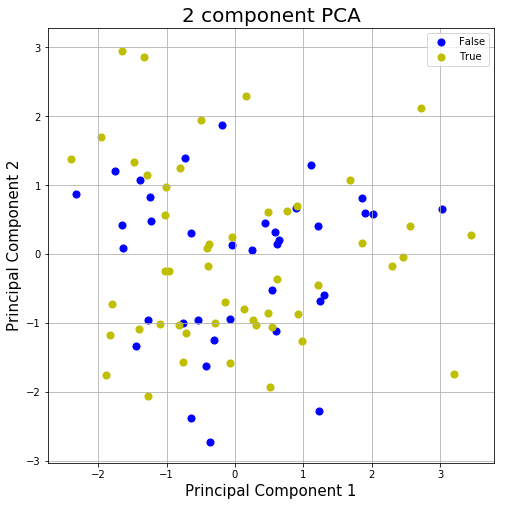

In [181]:
principalDf = pd.DataFrame(data = X_pca_train, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, Y_train], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [False, True]
colors = ['b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['fake'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Dimensional reduction with LDA

In [182]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda_model = LDA(n_components = 20)
X_lda_train = lda_model.fit(X_std_train, Y_train).transform(X_std_train)
X_lda_test = lda_model.transform(X_std_test)

### Dimensional reduction with QDA

In [183]:
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
#qda_model = QDA()
#X_qda_train = qda_model.fit(X_std_train, Y_train)
#X_qda_train

In [184]:
#X_qda_test = lda_model.transform(X_std_test)

### Binary Classification with SVM

### From PCA Reduction

In [185]:
print('For rbf:', svc_param_selection(X_pca_train, Y_train, 2, 'rbf'))
print('For linear:', svc_param_selection(X_pca_train, Y_train, 2, 'linear'))
print('For poly:', svc_param_selection(X_pca_train, Y_train, 2, 'poly'))
print('For sigmoid:', svc_param_selection(X_pca_train, Y_train, 2, 'sigmoid'))

/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


For rbf: {'C': 10, 'gamma': 0.01}


/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


For linear: {'C': 0.1, 'gamma': 0.001}


/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


For poly: {'C': 1, 'gamma': 1}
For sigmoid: {'C': 0.1, 'gamma': 1}


/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [186]:
models = {}
models['rbf'] = svm.SVC(kernel='rbf', gamma=0.01, C= 10)
models['linear']  = svm.SVC(kernel='linear', gamma=0.001, C= 0.1)
models['poly']  = svm.SVC(kernel='poly', gamma=1, C= 1)
models['sigmoid'] = svm.SVC(kernel='sigmoid', gamma=1, C= 0.1)

In [187]:
scores = s.run_models(models, X_pca_train, Y_train, X_pca_test, Y_test)
for model in scores:
    print('For model', model)
    print('Training score: {}. Test score: {}'.format(scores[model]['train'],scores[model]['test']))

For model rbf
Training score: 0.6972477064220184. Test score: 0.6363636363636364
For model linear
Training score: 0.7064220183486238. Test score: 0.6363636363636364
For model poly
Training score: 0.6880733944954128. Test score: 0.875
For model sigmoid
Training score: 0.6605504587155964. Test score: 0.5


In [188]:
def plot_scikit_lda(X,y, title):
    label_dict = {0: 'Real', 1: 'Fake'}
    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(0,2),('^', 's'),('blue', 'red')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

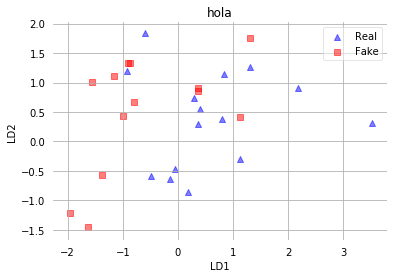

In [189]:
plot_scikit_lda(X_pca_test,Y_test, 'hola')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


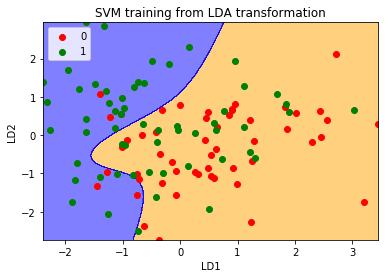

In [197]:
X_set, y_set = X_pca_train, Y_train

aranged_pc1 = np.arange(start = X_set[:, 0].min(), stop = X_set[:, 0].max(), step = 0.01)
aranged_pc2 = np.arange(start = X_set[:, 1].min(), stop = X_set[:, 1].max(), step = 0.01)

X1, X2 = np.meshgrid(aranged_pc1, aranged_pc2)
plt.contourf(X1, X2, models['poly'].predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
alpha = 0.5, cmap = ListedColormap(('orange', 'blue')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM training from LDA transformation')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


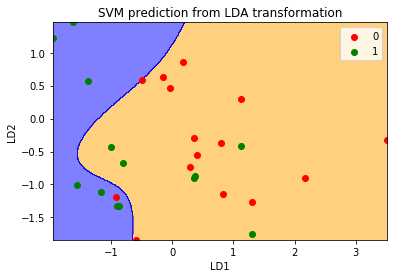

In [198]:
X_set, y_set = X_pca_test, Y_test

aranged_pc1 = np.arange(start = X_set[:, 0].min(), stop = X_set[:, 0].max(), step = 0.01)
aranged_pc2 = np.arange(start = X_set[:, 1].min(), stop = X_set[:, 1].max(), step = 0.01)

X1, X2 = np.meshgrid(aranged_pc1, aranged_pc2)
plt.contourf(X1, X2, models['poly'].predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
alpha = 0.5, cmap = ListedColormap(('orange', 'blue')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM prediction from LDA transformation')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

### From LDA reduction

In [163]:
print('For rbf:', svc_param_selection(X_lda_train, Y_train, 2, 'rbf'))
print('For linear:', svc_param_selection(X_lda_train, Y_train, 2, 'linear'))
print('For poly:', svc_param_selection(X_lda_train, Y_train, 2, 'poly'))
print('For sigmoid:', svc_param_selection(X_lda_train, Y_train, 2, 'sigmoid'))

/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


For rbf: {'C': 1, 'gamma': 1}


/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


For linear: {'C': 1, 'gamma': 0.001}


/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


For poly: {'C': 0.01, 'gamma': 1}
For sigmoid: {'C': 10, 'gamma': 0.1}


/home/elenaruiz/Documents/FNC/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [164]:
models = {}
models['rbf'] = svm.SVC(kernel='rbf', gamma=1, C= 1)
models['linear']  = svm.SVC(kernel='linear', gamma=0.001, C= 1)
models['poly']  = svm.SVC(kernel='poly', gamma=1, C= 0.01)
models['sigmoid'] = svm.SVC(kernel='sigmoid', gamma=0.1, C= 10)

In [165]:
scores = s.run_models(models, X_lda_train, Y_train, X_lda_test, Y_test)
for model in scores:
    print('For model', model)
    print('Training score: {}. Test score: {}'.format(scores[model]['train'],scores[model]['test']))

For model rbf
Training score: 0.7614678899082569. Test score: 0.6428571428571429
For model linear
Training score: 0.7614678899082569. Test score: 0.6428571428571429
For model poly
Training score: 0.6330275229357798. Test score: 0.5263157894736842
For model sigmoid
Training score: 0.7614678899082569. Test score: 0.6428571428571429


### Binary Classification with Random Forest

In [99]:
from src.fake_news_detector.core.classificators import helpers as h
from sklearn.ensemble import RandomForestClassifier

In [25]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_pca_train, Y_train)
Y_pred = clf.predict(X_pca_test)
scrore_train, score_test = h.print_evaluation(clf, X_pca_train, Y_train, Y_test, Y_pred, False)

print('Training score: {}. Test score: {}'.format(scrore_train,score_test))

Training score: 0.7555555555555555. Test score: 0.5625


In [100]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_lda_train, Y_train)
Y_pred = clf.predict(X_lda_test)
scrore_train, score_test = h.print_evaluation(clf, X_lda_train, Y_train, Y_test, Y_pred, False)

print('Training score: {}. Test score: {}'.format(scrore_train,score_test))

Training score: 0.7706422018348624. Test score: 0.6153846153846154
